compare Mel0703E1__B1_focal_start2setseed--cv9335
- now B3

# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0704A1'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0630B1' #MelPrp0630B1__resize_to600
param.ARCH = 'efficientnet-b3'


from efficientnet_pytorch import EfficientNet
param.SZ = EfficientNet.get_image_size(param.ARCH) 

param.EPOCHS = 80

# p2: efficientnet-b1 64
param.BS = 40

param.K=5; param.SEED=101; param.FLD2USE=0
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.RandomResizedCrop_scale=(0.75, 1.0)

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.EPOCHS = 5
    param.K = 5
    param.N_SAMPL = 2048

DEVICE = 'cuda'; PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0704A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0630B1',
 'ARCH': 'efficientnet-b3',
 'SZ': 300,
 'EPOCHS': 80,
 'BS': 40,
 'K': 5,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Sat Jul  4 12:29:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   55C    P0    62W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings
warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58457, 4)


,source,im_pth,patient_id,target
24437,20,../output/MelPrp0630B1/siim-isic-melanoma-clas...,IP_4021847,0.0
57432,19,../output/MelPrp0630B1/andrewmvd--isic-2019/IS...,BCN_0004730,1.0


(58457, 4)

20    33126
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017630
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


/data/anaconda3/envs/mel/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl={fld:(tr,vl) for fld,(tr,vl) in enumerate(kf.split(dftrn, groups=dftrn.patient_id))}

for fld, (tr, vl) in fld2trvl.items():
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())


0 46765 11692
1 46765 11692
2 46766 11691
3 46766 11691
4 46766 11691


0.0    0.913953
1.0    0.086047
Name: target, dtype: float64

0.0    0.911066
1.0    0.088934
Name: target, dtype: float64

0.0    0.915173
1.0    0.084827
Name: target, dtype: float64

0.0    0.91218
1.0    0.08782
Name: target, dtype: float64

0.0    0.910897
1.0    0.089103
Name: target, dtype: float64

20    26536
19    20229
Name: source, dtype: int64

20    26644
19    20121
Name: source, dtype: int64

20    26529
19    20237
Name: source, dtype: int64

20    26491
19    20275
Name: source, dtype: int64

20    26304
19    20462
Name: source, dtype: int64

# dataset

In [7]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if mode=='trn':
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.RandomBrightnessContrast(),
                A.HueSaturationValue(
                    hue_shift_limit=10,
                    sat_shift_limit=20,
                    p=1),
                A.CLAHE(),
                A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
        else:
            self.composed = A.Compose([
                A.Resize(param.SZ, param.SZ),
                A.Normalize(),
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode in ('trn', 'val'):
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [8]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    dstrn = MelDataset(dftrn, mode='trn')
    print(dstrn[0][0].shape)
    plt.imshow(dstrn[0][0].permute(1, 2, 0))

# model

In [9]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [10]:
# mdl = mkmdl()

# train

In [11]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
        y.append(yb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## set up model

In [12]:
mdl = mkmdl()
mdl = mdl.to(device)

if param.PRFX_B4 is not None: 
    fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.FLD2USE_B4}_best.p'
    print('load previously trained', fnm_mdl_b4)
    mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))


# opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
mdl.zero_grad()


Loaded pretrained weights for efficientnet-b3


## set up data

In [13]:
tr,vl=fld2trvl[param.FLD2USE]
dftr=dftrn.iloc[tr]
dfvl=dftrn.iloc[vl]
ystr=dftr.target.values
ysvl=dfvl.target.values
print(len(dftr), len(dfvl))
dstr = MelDataset(dftr, mode='trn')
dsvl = MelDataset(dfvl, mode='val')
print(len(dstr), len(dsvl))
dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltr), len(dlvl))
lendl=len(dltr)

46765 11692
46765 11692
1170 147


## set up results

In [14]:
results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param

stats = {
    'lss': {'tr':[],'vl':[]},
    'scr': {'tr':[],'vl':[]},
}
oof = {'y':[], 'prd':[]}


def save_results():
    results['oof'] = oof
    stats['best_scr'] = best_scr
    stats['best_epc'] = best_epc
    results['stats'] = stats
    pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))

## focal loss

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

## run train

In [16]:
set_seed(param.SEED)
best_scr = float('-inf')
best_epc = -1
for epc in range(param.EPOCHS):
    prdtr_ep=[]
    ytr_ep=[]
    for step, dat in enumerate(dltr):
        mdl.train()
        xb,yb=(o.to(device) for o in dat)
        yb = yb.unsqueeze(1)
        prdb = mdl(xb)
#         loss = F.binary_cross_entropy_with_logits(prdb, yb)
        loss =  loss_fn(prdb,yb)
        if param.FP16:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        if param.FP16:
            torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
        else:
            torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
        opt.step()
        opt.zero_grad()
        prdtr_ep.append(prdb.cpu().detach().numpy())
        ytr_ep.append(yb.cpu().detach().numpy())
        if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')
    
    prdtr_ep = np.concatenate(prdtr_ep)
    ytr_ep = np.concatenate(ytr_ep)    
    lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
    scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
    stats['lss']['tr'].append(lss_tr_ep)
    stats['scr']['tr'].append(scr_tr_ep)
    
    lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
    stats['lss']['vl'].append(lss_vl_ep)
    stats['scr']['vl'].append(scr_vl_ep)
    oof['y'].append(yvl_ep)
    oof['prd'].append(prdvl_ep)
    
    print(dtnow(), f'ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')
    
    if scr_vl_ep>best_scr:
        print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
        best_scr = scr_vl_ep
        best_epc = epc
        torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p')
    if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_epc_{epc}.p')
        
    schdl.step(scr_vl_ep)  # Update learning rate schedule
    save_results()    
    

/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 12:36:03 ep 0 step 1000/1170
2020-07-04 12:37:32 ep 0: lss_tr 0.387; lss_vl 0.357; scr_tr 0.828; scr_vl 0.886; 
better scr -inf -> 0.886


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 12:43:47 ep 1 step 1000/1170
2020-07-04 12:45:15 ep 1: lss_tr 0.373; lss_vl 0.363; scr_tr 0.867; scr_vl 0.897; 
better scr 0.886 -> 0.897


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 12:51:32 ep 2 step 1000/1170
2020-07-04 12:53:00 ep 2: lss_tr 0.366; lss_vl 0.346; scr_tr 0.877; scr_vl 0.905; 
better scr 0.897 -> 0.905


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 12:59:18 ep 3 step 1000/1170
2020-07-04 13:00:46 ep 3: lss_tr 0.362; lss_vl 0.328; scr_tr 0.883; scr_vl 0.909; 
better scr 0.905 -> 0.909


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:07:04 ep 4 step 1000/1170
2020-07-04 13:08:33 ep 4: lss_tr 0.358; lss_vl 0.377; scr_tr 0.887; scr_vl 0.914; 
better scr 0.909 -> 0.914


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:14:48 ep 5 step 1000/1170
2020-07-04 13:16:16 ep 5: lss_tr 0.348; lss_vl 0.360; scr_tr 0.895; scr_vl 0.906; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:22:35 ep 6 step 1000/1170
2020-07-04 13:24:04 ep 6: lss_tr 0.348; lss_vl 0.285; scr_tr 0.897; scr_vl 0.913; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:30:26 ep 7 step 1000/1170
2020-07-04 13:31:57 ep 7: lss_tr 0.347; lss_vl 0.356; scr_tr 0.901; scr_vl 0.914; 
better scr 0.914 -> 0.914


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:38:27 ep 8 step 1000/1170
2020-07-04 13:39:59 ep 8: lss_tr 0.342; lss_vl 0.353; scr_tr 0.904; scr_vl 0.885; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:46:26 ep 9 step 1000/1170
2020-07-04 13:47:57 ep 9: lss_tr 0.337; lss_vl 0.306; scr_tr 0.908; scr_vl 0.914; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 13:54:33 ep 10 step 1000/1170
2020-07-04 13:56:09 ep 10: lss_tr 0.332; lss_vl 0.343; scr_tr 0.913; scr_vl 0.923; 
better scr 0.914 -> 0.923


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:02:44 ep 11 step 1000/1170
2020-07-04 14:04:12 ep 11: lss_tr 0.329; lss_vl 0.338; scr_tr 0.916; scr_vl 0.916; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:10:31 ep 12 step 1000/1170
2020-07-04 14:12:00 ep 12: lss_tr 0.325; lss_vl 0.343; scr_tr 0.918; scr_vl 0.904; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:18:16 ep 13 step 1000/1170
2020-07-04 14:19:44 ep 13: lss_tr 0.322; lss_vl 0.342; scr_tr 0.923; scr_vl 0.921; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:26:10 ep 14 step 1000/1170
2020-07-04 14:27:40 ep 14: lss_tr 0.319; lss_vl 0.317; scr_tr 0.924; scr_vl 0.873; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:34:03 ep 15 step 1000/1170
2020-07-04 14:35:30 ep 15: lss_tr 0.312; lss_vl 0.293; scr_tr 0.928; scr_vl 0.924; 
better scr 0.923 -> 0.924


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:41:47 ep 16 step 1000/1170
2020-07-04 14:43:15 ep 16: lss_tr 0.315; lss_vl 0.314; scr_tr 0.927; scr_vl 0.919; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:49:38 ep 17 step 1000/1170
2020-07-04 14:51:07 ep 17: lss_tr 0.314; lss_vl 0.289; scr_tr 0.929; scr_vl 0.931; 
better scr 0.924 -> 0.931


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 14:57:24 ep 18 step 1000/1170
2020-07-04 14:58:52 ep 18: lss_tr 0.309; lss_vl 0.340; scr_tr 0.932; scr_vl 0.912; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:05:12 ep 19 step 1000/1170
2020-07-04 15:06:41 ep 19: lss_tr 0.299; lss_vl 0.288; scr_tr 0.937; scr_vl 0.918; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:13:01 ep 20 step 1000/1170
2020-07-04 15:14:29 ep 20: lss_tr 0.303; lss_vl 0.290; scr_tr 0.937; scr_vl 0.934; 
better scr 0.931 -> 0.934


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:20:47 ep 21 step 1000/1170
2020-07-04 15:22:17 ep 21: lss_tr 0.295; lss_vl 0.282; scr_tr 0.940; scr_vl 0.922; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:28:37 ep 22 step 1000/1170
2020-07-04 15:30:05 ep 22: lss_tr 0.292; lss_vl 0.297; scr_tr 0.942; scr_vl 0.916; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:36:23 ep 23 step 1000/1170
2020-07-04 15:37:50 ep 23: lss_tr 0.285; lss_vl 0.298; scr_tr 0.943; scr_vl 0.913; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:44:17 ep 24 step 1000/1170
2020-07-04 15:46:08 ep 24: lss_tr 0.285; lss_vl 0.334; scr_tr 0.946; scr_vl 0.914; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 15:53:45 ep 25 step 1000/1170
2020-07-04 15:55:59 ep 25: lss_tr 0.284; lss_vl 0.253; scr_tr 0.948; scr_vl 0.926; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 16:06:53 ep 26 step 1000/1170
2020-07-04 16:09:57 ep 26: lss_tr 0.278; lss_vl 0.287; scr_tr 0.950; scr_vl 0.930; 
Epoch    27: reducing learning rate of group 0 to 5.0000e-04.


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 16:20:51 ep 27 step 1000/1170
2020-07-04 16:23:08 ep 27: lss_tr 0.258; lss_vl 0.245; scr_tr 0.961; scr_vl 0.926; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 16:34:59 ep 28 step 1000/1170
2020-07-04 16:37:15 ep 28: lss_tr 0.247; lss_vl 0.251; scr_tr 0.965; scr_vl 0.932; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 16:48:10 ep 29 step 1000/1170
2020-07-04 16:50:26 ep 29: lss_tr 0.239; lss_vl 0.252; scr_tr 0.967; scr_vl 0.933; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 17:02:10 ep 30 step 1000/1170
2020-07-04 17:04:30 ep 30: lss_tr 0.235; lss_vl 0.241; scr_tr 0.969; scr_vl 0.928; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 17:15:39 ep 31 step 1000/1170
2020-07-04 17:18:20 ep 31: lss_tr 0.231; lss_vl 0.247; scr_tr 0.971; scr_vl 0.929; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 17:29:22 ep 32 step 1000/1170
2020-07-04 17:31:37 ep 32: lss_tr 0.221; lss_vl 0.254; scr_tr 0.974; scr_vl 0.932; 
Epoch    33: reducing learning rate of group 0 to 2.5000e-04.


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 17:42:31 ep 33 step 1000/1170
2020-07-04 17:45:35 ep 33: lss_tr 0.215; lss_vl 0.229; scr_tr 0.978; scr_vl 0.933; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 17:56:30 ep 34 step 1000/1170
2020-07-04 17:58:45 ep 34: lss_tr 0.201; lss_vl 0.213; scr_tr 0.981; scr_vl 0.934; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 18:10:27 ep 35 step 1000/1170
2020-07-04 18:12:43 ep 35: lss_tr 0.194; lss_vl 0.212; scr_tr 0.982; scr_vl 0.933; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 18:23:37 ep 36 step 1000/1170
2020-07-04 18:25:53 ep 36: lss_tr 0.193; lss_vl 0.220; scr_tr 0.983; scr_vl 0.925; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 18:37:37 ep 37 step 1000/1170
2020-07-04 18:39:52 ep 37: lss_tr 0.186; lss_vl 0.210; scr_tr 0.985; scr_vl 0.930; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 18:50:45 ep 38 step 1000/1170
2020-07-04 18:53:15 ep 38: lss_tr 0.181; lss_vl 0.206; scr_tr 0.985; scr_vl 0.933; 
Epoch    39: reducing learning rate of group 0 to 1.2500e-04.


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 19:04:27 ep 39 step 1000/1170
2020-07-04 19:06:42 ep 39: lss_tr 0.175; lss_vl 0.200; scr_tr 0.987; scr_vl 0.932; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 19:17:39 ep 40 step 1000/1170
2020-07-04 19:20:44 ep 40: lss_tr 0.168; lss_vl 0.193; scr_tr 0.988; scr_vl 0.933; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 19:31:48 ep 41 step 1000/1170
2020-07-04 19:34:06 ep 41: lss_tr 0.165; lss_vl 0.197; scr_tr 0.989; scr_vl 0.929; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 19:45:46 ep 42 step 1000/1170
2020-07-04 19:48:03 ep 42: lss_tr 0.162; lss_vl 0.202; scr_tr 0.989; scr_vl 0.929; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 19:58:57 ep 43 step 1000/1170
2020-07-04 20:01:12 ep 43: lss_tr 0.160; lss_vl 0.200; scr_tr 0.990; scr_vl 0.923; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 20:12:59 ep 44 step 1000/1170
2020-07-04 20:15:17 ep 44: lss_tr 0.158; lss_vl 0.204; scr_tr 0.990; scr_vl 0.928; 
Epoch    45: reducing learning rate of group 0 to 6.2500e-05.


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 20:26:19 ep 45 step 1000/1170
2020-07-04 20:28:37 ep 45: lss_tr 0.158; lss_vl 0.197; scr_tr 0.990; scr_vl 0.929; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 20:40:05 ep 46 step 1000/1170
2020-07-04 20:42:21 ep 46: lss_tr 0.155; lss_vl 0.197; scr_tr 0.991; scr_vl 0.928; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 20:53:15 ep 47 step 1000/1170
2020-07-04 20:56:18 ep 47: lss_tr 0.151; lss_vl 0.197; scr_tr 0.992; scr_vl 0.928; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2020-07-04 21:07:27 ep 48 step 1000/1170
2020-07-04 21:09:43 ep 48: lss_tr 0.149; lss_vl 0.195; scr_tr 0.992; scr_vl 0.927; 


/data/anaconda3/envs/mel/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Traceback (most recent call last):
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## run done

In [17]:
print(f'best_scr {best_scr:.4f}; best_epc {best_epc}')

best_scr 0.9343; best_epc 20


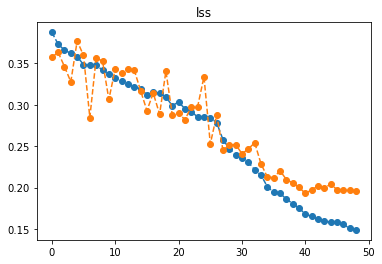

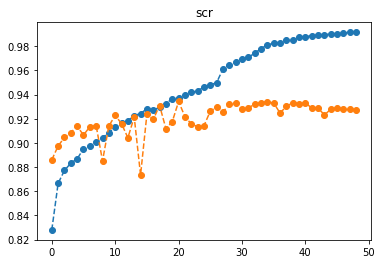

In [18]:
for mtrc in ['lss', 'scr']:
    recs=stats[mtrc]
    for tv,vs in recs.items():
        plt.title(f'{mtrc}')
        plt.plot(vs, 'o--')
    plt.show()

# inference

In [19]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0630B1/siim-isic-melanoma-clas...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0630B1/siim-isic-melanoma-clas...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0630B1/siim-isic-melanoma-clas...


10982
138


In [20]:
mdl = mkmdl()
fnm_mdl = f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p'
print('load model', fnm_mdl)
mdl.load_state_dict(torch.load(fnm_mdl, map_location=torch.device(DEVICE)))

mdl = mdl.to(device)

Loaded pretrained weights for efficientnet-b3
load model ../output/Mel0704A1/model_Mel0704A1_fld_0_best.p


In [21]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    return prd

In [22]:
%%time
prdtst = infer(mdl, dltst)

2020-07-04 21:18:33 step 0/138
CPU times: user 19.3 s, sys: 6.77 s, total: 26.1 s
Wall time: 29.4 s


In [23]:
dfsub.target = sigmoid(prdtst)
print(dfsub.target.mean())
dfsub.head()

0.19855862855911255


,image_name,target
0,ISIC_0052060,0.054803
1,ISIC_0052349,0.039639
2,ISIC_0058510,0.011376
3,ISIC_0073313,0.086478
4,ISIC_0073502,0.218003


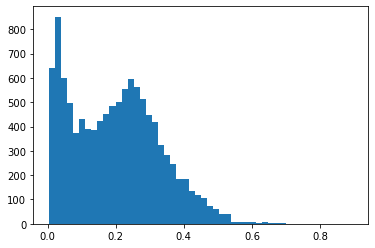

In [24]:
plt.hist(dfsub.target, bins=50);

In [25]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}.csv', index=False)

# fin

In [26]:
print(f'best_scr {best_scr:.4f}; best_epc {best_epc}')

best_scr 0.9343; best_epc 20


In [27]:
param.__dict__

{'PRFX': 'Mel0704A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0630B1',
 'ARCH': 'efficientnet-b3',
 'SZ': 300,
 'EPOCHS': 80,
 'BS': 40,
 'K': 5,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [28]:
!nvidia-smi

Sat Jul  4 21:19:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   63C    P0    69W / 300W |  15763MiB / 16160MiB |     50%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  